In [152]:
import cv2
import os
import random
import uuid
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
from matplotlib import pyplot as plt

In [2]:
positive_path = os.path.join('data', 'positive')
negative_path = os.path.join('data', 'negative')
anchor_path = os.path.join('data', 'anchor')

In [ ]:
# # Make the directories if there are no directories
# os.makedirs(positive_path)
# os.makedirs(negative_path)
# os.makedirs(anchor_path)

In [3]:
# # Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [4]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(negative_path, file)
#         os.replace(EX_PATH, NEW_PATH)

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(anchor_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(positive_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [10]:
#get image from directories
tes_anchor_img = tf.data.Dataset.list_files(anchor_path+'\*.jpg').take(300)
tes_positive_img = tf.data.Dataset.list_files(positive_path+'\*.jpg').take(300)
tes_negative_img = tf.data.Dataset.list_files(negative_path+'\*.jpg').take(300)

In [20]:
dir_test = tes_anchor_img.as_numpy_iterator()

In [24]:
print(dir_test.next())

b'data\\anchor\\0ceedc70-9d7b-11ee-82f2-14cb19722a62.jpg'


In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

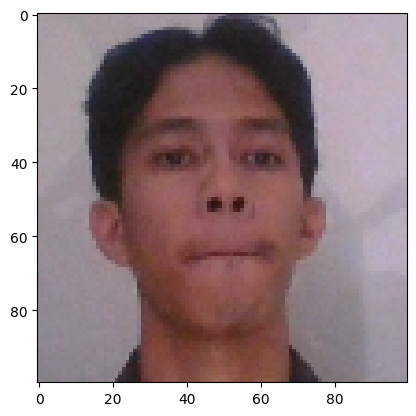

In [25]:
img = preprocess('data\\anchor\\0ceedc70-9d7b-11ee-82f2-14cb19722a62.jpg')
plt.imshow(img)

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [26]:
positives = tf.data.Dataset.zip((tes_anchor_img, tes_positive_img, tf.data.Dataset.from_tensor_slices(tf.ones(len(tes_anchor_img)))))
negatives = tf.data.Dataset.zip((tes_anchor_img, tes_negative_img, tf.data.Dataset.from_tensor_slices(tf.zeros(len(tes_anchor_img)))))
data = positives.concatenate(negatives)

In [39]:
samples = data.as_numpy_iterator()

In [45]:
example = samples.next()

In [46]:
example

(b'data\\anchor\\12345e70-9d7b-11ee-a1f8-14cb19722a62.jpg',
 b'data\\positive\\470d2151-9d7b-11ee-a918-14cb19722a62.jpg',
 1.0)

In [47]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [49]:
res = preprocess_twin(*example)

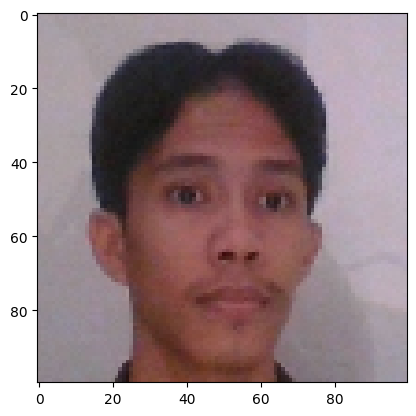

In [50]:
plt.imshow(res[1])

In [51]:
res[2]

1.0

In [52]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [105]:
# Training partition
traindata = data.take(round(len(data)*.7))
traindata = traindata.batch(16)
traindata = traindata.prefetch(8)

In [106]:
# Testing partition
testdata = data.skip(round(len(data)*.7))
testdata = testdata.take(round(len(data)*.3))
testdata = testdata.batch(16)
testdata = testdata.prefetch(8)

In [107]:
#create embedding layer
def make_embedding():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (10,10), input_shape=(100,100,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(64, (2,2), padding='same'),
        tf.keras.layers.Conv2D(128,(7,7), activation='relu'),
        tf.keras.layers.MaxPooling2D(64, (2,2), padding='same'),
        tf.keras.layers.Conv2D(128,(4,4), activation='relu'),
        tf.keras.layers.MaxPooling2D(64, (2,2), padding='same'),
        tf.keras.layers.Conv2D(256,(4,4), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='sigmoid')
    ])
    return model

In [110]:
embedding_model = make_embedding()
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       262272    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 128)         0

In [113]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [114]:
# l1 = L1Dist()

In [127]:
# l1(anchor_embedding, validation_embedding)

In [125]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [126]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential (Sequential)     (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [128]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [129]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [143]:
test_batch = traindata.as_numpy_iterator()
batch1 = test_batch.next()

In [145]:
X = batch1[:2]

In [149]:
y = batch1[2]

In [150]:
y

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [151]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [153]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# def train(data, EPOCHS):
#     # Loop through epochs
#     for epoch in range(1, EPOCHS+1):
#         print('\n Epoch {}/{}'.format(epoch, EPOCHS))
#         progbar = tf.keras.utils.Progbar(len(data))
        
#         # Loop through each batch
#         for idx, batch in enumerate(data):
#             # Run train step here
#             train_step(batch)
#             progbar.update(idx+1)
        
#         # Save checkpoints
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 5
train(traindata, EPOCHS)

In [157]:
test_input, test_val, y_true = testdata.as_numpy_iterator().next()

In [158]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[7.6924698e-05],
       [1.4463026e-06],
       [5.1874608e-06],
       [1.8481946e-02],
       [3.4141540e-05],
       [6.4735971e-03],
       [8.4714929e-07],
       [9.8086619e-01],
       [7.2139782e-01],
       [5.7658314e-04],
       [6.0037696e-06],
       [1.8206880e-04],
       [7.6721549e-01],
       [3.3707875e-06],
       [9.8816025e-01],
       [1.7866543e-05]], dtype=float32)

In [159]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]

In [160]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

In [161]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [162]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

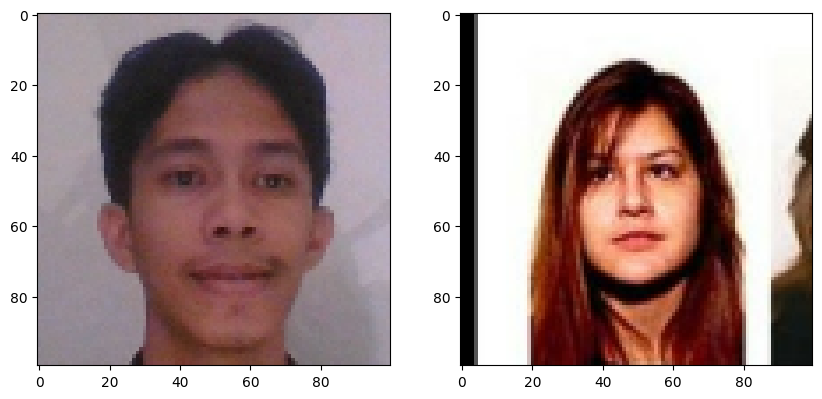

In [173]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [169]:
# Save model
siamese_model.save('siamesemodel2.h5')

c:\users\crozi\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [170]:
L1Dist

__main__.L1Dist

In [171]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [172]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 sequential (Sequential)     (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     